# DQN implementation in JAX

I will implement the DQN algorithm as proposed by the following paper [1]. I will try to make the model as general as possible, so that it can be used for any type of problem. The model will be implemented in JAX, so that fast training and testing will be possible with the model.

**References:**

[1] M Roderick et al. 2017, Implementing the Deep Q-Network

In [6]:
!pip install gymnasium[classic_control] 
!pip install optax
!pip install jax[cpu]
# Decided to go for different environments, as I don't have mujoco

  Using cached optax-0.2.3-py3-none-any.whl.metadata (8.3 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
Using cached optax-0.2.3-py3-none-any.whl (289 kB)
Using cached absl_py-2.1.0-py3-none-any.whl (133 kB)
   ---------------------------------------- 0.0/99.4 kB ? eta -:--:--
   ---------------------------------------- 99.4/99.4 kB 5.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ----------- ---------------------------- 0.6/2.1 MB 19.2 MB/s eta 0:00:01
   ---------------------------------- ----- 1.8/2.1 MB 22.8 MB/s eta 0:00:01
   ---------------------------------------- 2.1/2.1 MB 16.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/54.4 MB ? eta -:--:--
    --------------------------------------- 1.2/54.4 MB 24.8 MB/s eta 0:00:03
   - -------------------------------------- 2.0/54.4 MB 26.0 MB/s eta 0:00:03
   -- ------------------------------------- 3.1/54.4 MB 25.1 MB/s eta 0:00:03
   --- -----------

In [8]:
# Import jax
import optax
import jax.numpy as jnp
from jax.nn import leaky_relu
from jax import grad, value_and_grad, jit, vmap
from jax.random import normal, uniform, PRNGKey, split, choice
from functools import partial
from operator import itemgetter
import matplotlib.pyplot as plt
from IPython.display import clear_output
import gymnasium as gym

In [36]:
# Neural network hard-coded version for Inverted Pendulum case

# class InvPendulumNN:
#     def __init__(self, in_size=5, out_size=1, hidden_size=10, a_func=relu, seed=42):
#         prng_key = PRNGKey(seed)
#         self.W1 = normal(prng_key,shape=(hidden_size,in_size))
#         self.W2 = normal(prng_key,shape=(out_size,hidden_size))
#         self.params = {"W1": self.W1, "W2": self.W2}
#         self.dW1 = jnp.zeros_like(self.W1)
#         self.dW2 = jnp.zeros_like(self.W2)
#         self.a_funcs = [a_func, a_func]
#     def predict_loss(self, params, x):
#         x_h = self.a_funcs[0](params["W1"] @ x)
#         return self.a_funcs[1](params["W2"] @ x_h)
#     def predict(self, x):
#         x_h = self.a_funcs[0](self.params["W1"] @ x)
#         return self.a_funcs[1](self.params["W2"] @ x_h)
#     def loss(self, params, batch):
#         x,y = batch
#         return jnp.square(y - self.predict_loss(params, x)).mean()
#     def parameters(self):
#         return self.params
#     def set_parameters(self, params):
#         self.params = params

class InvPendulumNNv2:
    def predict(params, x):
        x_h = leaky_relu(params["W1"] @ x)
        #x_h2 = leaky_relu(params["W2"] @ x_h)
        r_bound = 8 # This is a reward bound specific to the pendulum problem of openai
        return params["W3"] @ x_h
    def loss(params, batch):
        x,y = batch
        return jnp.square(y - InvPendulumNNv2.predict(params, x)).mean()
    def generate_params(key, in_size=5, hidden_size=10, out_size=1):
        key, *subkeys = split(key, num=4)
        val = 0.2
        return {
            "W1":uniform(subkeys[0],shape=(hidden_size,in_size), minval=-val, maxval=val),
            "W2":uniform(subkeys[1],shape=(hidden_size,hidden_size), minval=-val, maxval=val),
            "W3":uniform(subkeys[2],shape=(out_size,hidden_size), minval=-val, maxval=val)
        }

In [58]:
# This cell block contains the general update mechanics for the parameters of a model
def update(parameters, batch, opt_state, optimizer=optax.adam, loss_func=InvPendulumNNv2.loss):
    params = parameters
    loss, grads = value_and_grad(loss_func)(params, batch)
    grads = {key: jnp.clip(val, -1,1) for key, val in grads.items()} # Clip the gradients to a [-1,1] range (should improve stability of DQN algorithm)
    updates, opt_state = optimizer.update(grads, opt_state)
    return optax.apply_updates(params, updates), opt_state

# Assumes the following data structure: data = (num_samples, batch_size)
# Should only be given a single mini-batch of data to train on at the time
#partial(jit, static_argnums=(3))
def train(X_train, y_train, params, optimizer, opt_state):
    # Code below updates at each sample of the batch
    # for i in range(X_train.shape[1]):
    #    params, opt_state = update(params, (X_train[:,i], y_train[:,i]), opt_state, optimizer=optimizer)
    # Code below updates once for the whole batch
    return update(params, (X_train, y_train), opt_state, optimizer=optimizer) # Returns: params, opt_state

In [60]:
# Example to test the train method
X_train = jnp.array([[1.,-1.2,-1.], [2.,3.2,-2.], [3.,6.1,-3.], [4.,1.,-4.], [-5.,-3., -5.]])
y_train = jnp.array([[10., 6., 3.]])
# print(X_train.shape)
# print(y_train.shape)
prng_key = PRNGKey(42)
params = InvPendulumNNv2.generate_params(prng_key, hidden_size=21)
print(InvPendulumNNv2.predict(params, X_train))
optimizer = optax.adam(1e-3)
opt_state = optimizer.init(params)
params, opt_state = train(X_train, y_train, params, optimizer, opt_state)
print(InvPendulumNNv2.predict(params, X_train))

[[0.36035773 0.7062068  0.82588935]]
[[0.3791014  0.73084825 0.8414222 ]]


### Notes

Okay so far I've figured out how to use the gradient method of jax as well as how to use the parameters and an optimizer to update the model iteratively over episodes. Next step will be to check it's performance one sample data from the OpenAI gym model. We will sample an episode of 500 steps in the environment, and use the retrieved data, to check if we can learn Q-values with this neural network. If we are able to do so, the next step will be to actually implement the DQN algorithm fully, with the neural network as a component of it. 

## Retrieve Pendulum Environment

In [62]:
env = gym.make('Pendulum-v1', render_mode="None")
#env = PendulumArbitraryState()
state, info = env.reset(seed=42)
state, r, terminated, truncated, info = env.step(jnp.array([-2]))
print(state)
env.close()

[-0.16571613  0.9861735   0.31927678]


## The full DQN Algorithm for the Inverted Pendulum Environment

In [144]:
SEED = 42
ACTION_RES = 3

def get_action(state, Q_params, key, eps=0.02, val_range=[-2,2], action_res=ACTION_RES):
    key, *subkeys = split(key, num=3) # Make a different key w.r.t the provided key (otherwise no random numbers are provided)
    choice = uniform(subkeys[0], minval=0, maxval=1)
    if choice <= eps:
        return jnp.array([uniform(subkeys[1], minval=val_range[0], maxval=val_range[1])])
    else: 
        return get_best_action(state, Q_params, val_range=val_range, action_res=action_res)

def get_best_action(state, Q_params, val_range=[-2,2], action_res=ACTION_RES):
    state = jnp.expand_dims(state, axis=0) # Needed to ensure correct concatenation
    states = jnp.repeat(state, action_res, axis=0)
    actions = jnp.linspace(val_range[0], val_range[1], action_res)
    actions = jnp.expand_dims(actions, axis=1) # Needed to ensure correct concatenation
    nn_input = jnp.concatenate((states, actions), axis=1).transpose() # With transpose we ensure (num_samples, batch_size) shape required for the NN
    ys = InvPendulumNNv2.predict(Q_params, nn_input)
    return actions[jnp.argmax(ys)] # Gets the best action out of our discretized space run through the network
    
def initialize_memory(env, size, key, a_range=[-2,2]):
    i = 0
    state, info = env.reset(seed=SEED)
    state_mem = jnp.zeros(shape=(size, 3)) # Shape should be: size * dim(state)
    next_state_mem = jnp.zeros(shape=(size, 3)) # Shape should be: size * dim(state)
    action_mem = jnp.zeros(shape=(size, 1)) # Shape should be: size * dim(action)
    r_mem = jnp.zeros(shape=(size, 1)) # Shape should be: size * dim(r)
    terminated_mem = jnp.full((size, 1), False)
    
    while i < size:
        key, subkey = split(key)
        action = uniform(subkey, shape=(1,), minval=a_range[0],maxval=a_range[1])
        next_state, r, terminated, truncated, info = env.step(action)
        # Update arrays
        state_mem, action_mem, r_mem, next_state_mem, terminated_mem = update_memory(i, (state_mem, state), 
                     (action_mem, action), 
                     (r_mem, r), 
                     (next_state_mem, next_state), 
                     (terminated_mem, terminated))
        # Update state
        state = next_state
        if terminated or truncated:
            state,info = env.reset(seed=SEED)
        i += 1
    return state_mem, action_mem, r_mem, next_state_mem, terminated_mem 
        
@jit
def update_memory(i, state_tuple, action_tuple, r_tuple, next_state_tuple, terminated_tuple):
    return state_tuple[0].at[i, :].set(state_tuple[1].flatten()), \
           action_tuple[0].at[i, :].set(action_tuple[1]), \
           r_tuple[0].at[i, :].set(r_tuple[1]), \
           next_state_tuple[0].at[i, :].set(next_state_tuple[1].flatten()), \
           terminated_tuple[0].at[i, :].set(terminated_tuple[1])
    
#@partial(jit, static_argnums=[6]) TODO: Make this method jit-able
def get_minibatch(states, actions, rs, next_states, terminated, params, key, batch_size=6, gamma=0.8):
    vget_action = vmap(get_best_action, (1, None), 1) # Vectorized version of the get_action method
    key, subkey = split(key)
    batch_indices = choice(subkey, jnp.arange(0,states.shape[0],1), shape=(batch_size,1))
    xs = jnp.concatenate((jnp.take_along_axis(states, jnp.repeat(batch_indices, states.shape[1], axis=1), axis=0), 
                                  jnp.take_along_axis(actions, batch_indices, axis=0)), axis=1).transpose()
    next_state_batch = jnp.take_along_axis(next_states, jnp.repeat(batch_indices, next_states.shape[1], axis=1), axis=0).transpose()
    actions = vget_action(next_state_batch, params)
    qvalues = InvPendulumNNv2.predict(params, jnp.concatenate((next_state_batch, actions), axis=0)).transpose()
    ys = jnp.where(jnp.take(terminated, batch_indices), 
                           jnp.take(rs, batch_indices),
                           jnp.take(rs, batch_indices) + (gamma*qvalues)
                          ).transpose()
    return xs, ys, qvalues.mean() # Next to the x and y training batch, we also return the average of the computed q-values
    

# TODO: make the method below jit-able (this would include rewriting an existing openAI environment in jax for optimal performance)
def DQN(num_episodes, lr=1e-3, eps=0.7, eps_min=0.1, eps_decay=0.99, gamma=0.98, memory_size=50000, batch_size=250, C=3, in_size=4, hidden_size=8):
    prng_key = PRNGKey(SEED)
    env = gym.make('Pendulum-v1', render_mode="None")
    state_mem, action_mem, r_mem, next_state_mem, terminated_mem = initialize_memory(env, memory_size, prng_key)
    e_returns = jnp.zeros(shape=(num_episodes,))
    avg_qvals = jnp.zeros(shape=(num_episodes,))
    Q_params = InvPendulumNNv2.generate_params(prng_key, in_size=in_size, hidden_size=hidden_size)
    Q_params_target = InvPendulumNNv2.generate_params(prng_key, in_size=in_size, hidden_size=hidden_size) # Same prng key as Q_params, so weights are the same :)
    Q_params_best = Q_params_target
    best_return = -9999 # Was not sure how to do -inf so put a big enough number here
    count = 0
    mem_i = 0
    # Initialize optimizer
    optimizer = optax.adam(lr) # For now I will use the adam optimizer
    opt_state = optimizer.init(Q_params)
    
    for e in range(num_episodes):
        e_done = False
        e_return = 0
        qval_avg = 0
        step = 0
        state,info = env.reset(seed=SEED) # The seed ensures the same arbitrary starting conditions for every episode
        while not e_done:
            # Sample an action
            action = get_action(state, Q_params, prng_key, eps=eps)
            next_state, r, terminated, truncated, info = env.step(action)
            step += 1
            e_return += r
            #print(e_return)
            # Update memory arrays
            state_mem, action_mem, r_mem, next_state_mem, terminated_mem = update_memory(mem_i, (state_mem, state), 
                                                                                         (action_mem, action), 
                                                                                         (r_mem, r), 
                                                                                         (next_state_mem, next_state), 
                                                                                         (terminated_mem, terminated))
            # Update state for next loop
            state = next_state
            # Update network based on randomly sampled mini-batch
            xs, ys, qval = get_minibatch(state_mem, action_mem, r_mem, next_state_mem, terminated_mem, Q_params_target, prng_key, batch_size=batch_size, gamma=gamma)
            qval_avg = ((step-1)*qval_avg+qval)/step
            Q_params, opt_state = train(xs, ys, Q_params, optimizer, opt_state)
            # Update the stale network with the most recent found weights after every C steps
            if count == C:
                count = 0
                Q_params_target = {key: jnp.copy(val) for key, val in Q_params.items()} 
                #print(Q_params_target["W1"])
            e_done = terminated or truncated # Ends the current episode when True
            count += 1 # Counter for regulating network updating
            mem_i = (mem_i + 1) % memory_size # Update the memory in sweeps with this index update
        if e_return > best_return:
            best_return = e_return
            Q_params_best = Q_params_target
        avg_qvals = avg_qvals.at[e].set(qval_avg)
        e_returns = e_returns.at[e].set(e_return) # Keep track off episode returns (rewards accumulated over the episode)
        eps *= eps_decay
        eps = max(eps, eps_min)
        # Print the current state of the algorithm
        clear_output(wait=True)
        print("Episode: ", e)
        print("Best return: ", best_return)
        print("Avg Q-value: ", qval_avg)
        print("Epsilon: ", eps)
        print("Current return: ", e_return)
    return Q_params_best, Q_params_target, e_returns, avg_qvals # Make sure to return the best and most recent weights of our model, and the returns obtained over the episodes
        
     

In [146]:
# Test DQN (it is working?)

best_params, newest_params, returns, qvals = DQN(100)

Episode:  99
Best return:  -942.9072777307539
Avg Q-value:  -153.80011
Epsilon:  0.2562226388912603
Current return:  -1213.7324309576445


Text(0.5, 1.0, 'Average Q-value per episode')

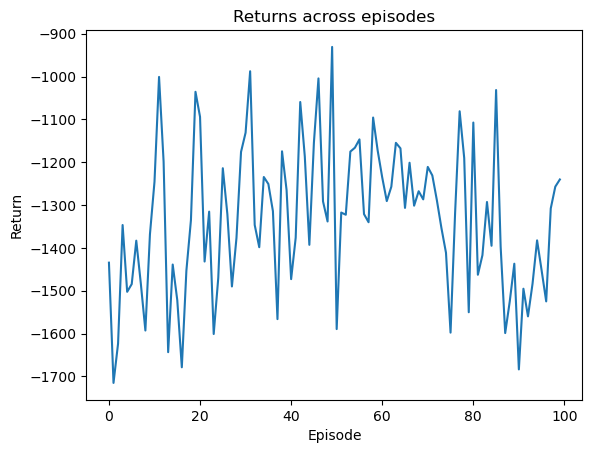

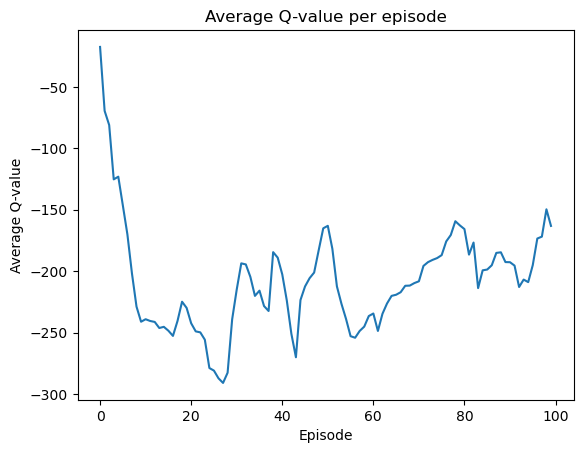

In [125]:
# Plot the returns obtained from the algorithm 
plt.figure()
plt.plot(returns)
plt.xlabel("Episode")
plt.ylabel("Return")
plt.title("Returns across episodes")
# Plot the qvalues obtained from the algorithm
plt.figure()
plt.plot(qvals)
plt.xlabel("Episode")
plt.ylabel("Average Q-value")
plt.title("Average Q-value per episode")

## Make a function to render the learned model on the environment

In [544]:
def render_DQN(env, params_learned):
    prng_key = PRNGKey(42)
    state,info = env.reset()
    env.render()
    done = False
    while not done:
        print("state:", state)
        action = get_best_action(state, params_learned)
        state, r, terminated, truncated, info = env.step(action)
        done = terminated or truncated
    env.close()

In [551]:
# Test rendering
env = gym.make('Pendulum-v1', render_mode="human")
prng_key = PRNGKey(42)
render_DQN(env, best_params)

state: [-0.01344309 -0.99990964 -0.31177244]
state: [-0.06622496 -0.9978047  -1.0565996 ]
state: [-0.14708169 -0.98912436 -1.626875  ]
state: [-0.24842422 -0.96865135 -2.0687182 ]
state: [-0.36702934 -0.93020934 -2.4952068 ]
state: [-0.5230765  -0.85228574 -3.492864  ]
state: [-0.69761306 -0.7164747  -4.432078  ]
state: [-0.8545072 -0.5194396 -5.0508156]
state: [-0.96660167 -0.2562834  -5.740395  ]
state: [-0.99862456  0.05243112 -6.232608  ]
state: [-0.9297293  0.3682438 -6.493284 ]
state: [-0.7629226   0.64648986 -6.517102  ]
state: [-0.5490358   0.83579886 -5.732234  ]
state: [-0.33437398  0.94244045 -4.805385  ]
state: [-0.15043984  0.98861915 -3.7985547 ]
state: [-0.00745287  0.9999722  -2.8712044 ]
state: [ 0.08351095  0.99650687 -1.8212253 ]
state: [ 0.12199593  0.9925306  -0.77384514]
state: [0.10855858 0.9940901  0.2705528 ]
state: [0.0429537 0.9990771 1.3161204]
state: [-0.07523333  0.997166    2.3654282 ]
state: [-0.24349687  0.9699017   3.4133027 ]
state: [-0.45110765  0.89